In [ ]:
# Test import from gridfm-graphkit to verify the path setup works 
import sys
import os
sys.path.append(os.path.abspath('../../gridfm-graphkit')) #Replace with the correct path

try:
    from gridfm_graphkit.datasets.powergrid_datamodule import LitGridDataModule
    from gridfm_graphkit.io.param_handler import NestedNamespace
    from gridfm_graphkit.tasks.feature_reconstruction_task import FeatureReconstructionTask
    from gridfm_graphkit.utils.visualization import (
        visualize_error,
        visualize_quantity_heatmap,
    )
    from gridfm_graphkit.datasets.globals import PD, QD, PG, QG, VM, VA
    print("✓ Successfully imported gridfm_graphkit modules!")
except ImportError as e:
    print(f"✗ Import failed: {e}")
    print("Make sure you're running this notebook from the correct directory and gridfm-graphkit is properly installed.")


✓ Successfully imported gridfm_graphkit modules!


In [ ]:
# Import from gridfm-datakit to access process_network functions
# ## datakit should be in opf branch ##
import sys
import os
sys.path.insert(0, os.path.abspath('../../gridfm-datakit')) #Replace with the correct path

try:
    from gridfm_datakit.process.process_network import (
        network_preprocessing,
        pf_preprocessing,
        pf_post_processing,
        process_scenario_unsecure,
        process_scenario_chunk,
        process_scenario_secure
    )
    from gridfm_datakit.process.solvers import run_pf, run_opf
    from gridfm_datakit.save import save_node_edge_data
except ImportError as e:
    print(f"✗ Import failed: {e}")
    print("Make sure you're running this notebook from the correct directory.")


In [3]:
# DEMONSTRATE GRIDSEARCH WITH CASE14
# https://dwightreid.com/site/power-system-contingency-analysis-with-python-pandapower/

import pandas as pd
import pandapower as pp
import pandapower.networks as ppnets
#from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly
import pandapower.plotting as plt
import pandapower.plotting.plotly as pplotly
import matplotlib.pyplot as mplt

In [4]:
net =  ppnets.case14() 

In [5]:
net

This pandapower network includes the following parameter tables:
   - bus (14 elements)
   - load (11 elements)
   - gen (4 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (5 elements)
   - poly_cost (5 elements)
   - bus_geodata (14 elements)

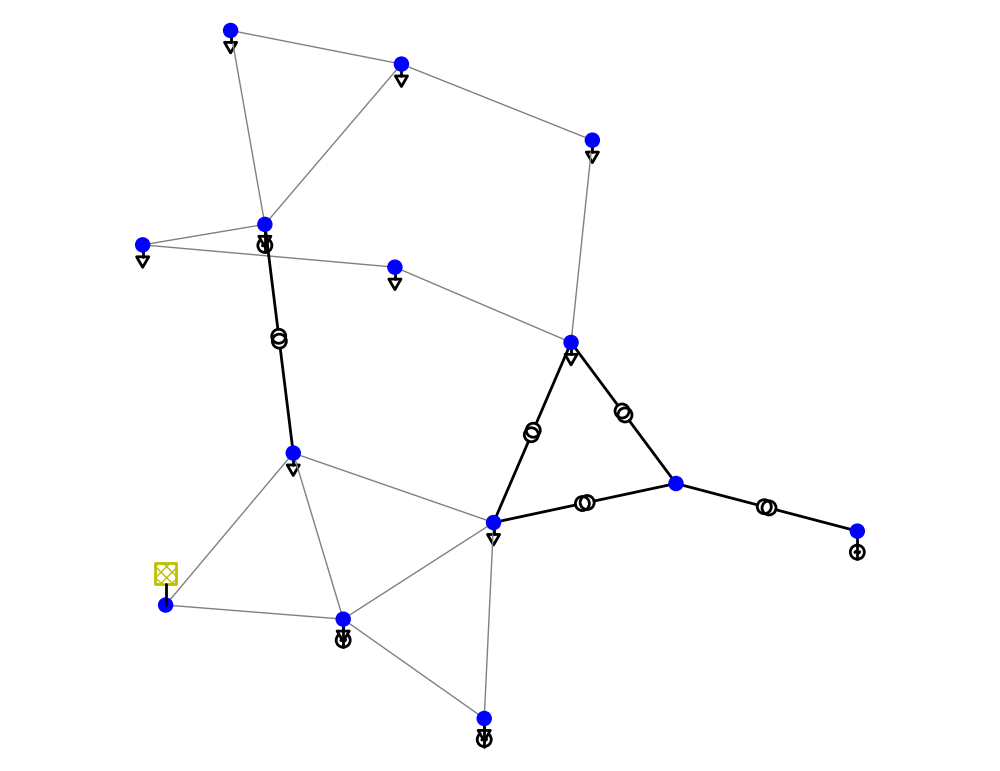

<Axes: >

In [6]:
plt.simple_plot(net,  plot_loads=True, plot_gens=True)

In [7]:
# disconnect from external grid - create an island
net.ext_grid['in_service']=False

In [8]:
# SHows all generator buses, and how much active power they prodcue., and 
# the voltage they are trying to maintain.
# why 1.045, 1.07, etc?
net.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,max_p_mw,min_p_mw
0,None,1,40.0,1.045,NaN,-40.0,50.0,1.0,False,True,0.0,None,True,140.0,0.0
1,None,2,0.0,1.010,NaN,0.0,40.0,1.0,False,True,0.0,None,True,100.0,0.0
2,None,5,0.0,1.070,NaN,-6.0,24.0,1.0,False,True,0.0,None,True,100.0,0.0
3,None,7,0.0,1.090,NaN,-6.0,24.0,1.0,False,True,0.0,None,True,100.0,0.0


In [9]:
net.gen['vm_pu']=1.045

In [10]:
# Perform a simple generator dispatch by maxing out the first three generators and setting the fourth one as the slack.
net.gen.loc[0,'p_mw'] = 140 
net.gen.loc[1,'p_mw'] = 100 
net.gen.loc[2,'p_mw'] = 100
net.gen.loc[3,'slack'] = True 

In [11]:
net.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,max_p_mw,min_p_mw
0,None,1,140.0,1.045,NaN,-40.0,50.0,1.0,False,True,0.0,None,True,140.0,0.0
1,None,2,100.0,1.045,NaN,0.0,40.0,1.0,False,True,0.0,None,True,100.0,0.0
2,None,5,100.0,1.045,NaN,-6.0,24.0,1.0,False,True,0.0,None,True,100.0,0.0
3,None,7,0.0,1.045,NaN,-6.0,24.0,1.0,True,True,0.0,None,True,100.0,0.0


In [12]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,controllable
0,None,1,21.7,12.7,0.0,0.0,NaN,1.0,True,None,False
1,None,2,94.2,19.0,0.0,0.0,NaN,1.0,True,None,False
2,None,3,47.8,-3.9,0.0,0.0,NaN,1.0,True,None,False
3,None,4,7.6,1.6,0.0,0.0,NaN,1.0,True,None,False
4,None,5,11.2,7.5,0.0,0.0,NaN,1.0,True,None,False
5,None,8,29.5,16.6,0.0,0.0,NaN,1.0,True,None,False
6,None,9,9.0,5.8,0.0,0.0,NaN,1.0,True,None,False
7,None,10,3.5,1.8,0.0,0.0,NaN,1.0,True,None,False
8,None,11,6.1,1.6,0.0,0.0,NaN,1.0,True,None,False
9,None,12,13.5,5.8,0.0,0.0,NaN,1.0,True,None,False


In [13]:
pp.runpp(net,numba=False)

In [14]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.040134,17.204662,0.000000,0.000000
1,1.045000,17.807919,-118.300000,-4.990003
2,1.045000,15.616964,-5.800000,-14.365044
3,1.008926,13.679667,47.800000,-3.900000
4,1.014580,15.004135,7.600000,1.600000
5,1.045000,16.407703,-88.800000,10.929587
6,1.019019,7.040958,0.000000,0.000000
7,1.045000,0.000000,74.102238,-19.972079
8,1.004872,8.025036,29.500000,-2.585581
9,1.001280,9.218494,9.000000,5.800000


In [15]:
# Real power: gen ?= load + shunt(consumption) + xward + losses + export
#P_rhs = P_load + max(P_shunt, 0.0) + P_xward + P_loss + P_export
#Q_rhs = Q_load + Q_loss + Q_shunt + Q_xward + Q_export

# the basic way
print('P_load = ' ,net.res_load['p_mw'].sum())
print('P_gen = ' ,net.res_gen['p_mw'].sum()+net.res_sgen['p_mw'].sum()+net.res_ext_grid['p_mw'].sum())
print('P_shunt = ',net.res_shunt['p_mw'].sum())
print('P_loss = ',net.res_line['pl_mw'].sum()+net.res_trafo['pl_mw'].sum())
print('***************************')
print('Q_load = ' ,net.res_load['q_mvar'].sum())
print('Q_gen = ' ,net.res_gen['q_mvar'].sum()+net.res_sgen['q_mvar'].sum()+net.res_ext_grid['q_mvar'].sum())
print('Q_shunt = ',net.res_shunt['q_mvar'].sum())
print('Q_loss = ',net.res_line['ql_mvar'].sum()+net.res_trafo['ql_mvar'].sum())

P_load =  259.0
P_gen =  265.8977620012312
P_shunt =  0.0
P_loss =  6.897762032213518
***************************
Q_load =  73.5
Q_gen =  67.59753784629032
Q_shunt =  -19.185580553825687
Q_loss =  13.283118503283424


Replace with gridfm finetuned model (case 14 now, later texas grid)
Best way to visualise the lo-voltages, high voltages and line overloading

In [16]:
import pandapower as pp
import pandas as pd
import numpy as np


scenarios = pd.read_excel("../data/load-scenarios.xlsx")
added_load_valued = [4,8,12,16,20]
added_load_values = [4,20]
q_p_ratio = 0.5
vmax, vmin = 1.05, 0.95
line_loading_max = 1.0

lines = net.line.index
bus_to_load = {int(row.bus): idx for idx, row in net.load.iterrows()}

summary_records = [] #counts of violation per scenario, bus, added load
detail_records = [] #detailed records of violations per scenario, bus, added load, line dropped
processed_data = [] #processed data from pandapower

network_preprocessing(net) #imported from gridfm_datakit.process.process_network

notConvergedCount = 0


# LOOP 1: iterate over load scenarios
# ============================================================
for i,scen_id in enumerate(scenarios['scenario'].unique()):
    if i>1:
        break
    scen_data = scenarios[scenarios['scenario'] == scen_id]
    print(f"\n=== Scenario {scen_id} ===")

    # set base case
    for _, row in scen_data.iterrows():
        bus = int(row['bus'])
        if bus in bus_to_load:
            load_idx = bus_to_load[bus]
            net.load.loc[load_idx, 'p_mw'] = row['p_mw']
            net.load.loc[load_idx, 'q_mvar'] = row['q_mvar']

    # ============================================================
    # LOOP 2: over buses
    # ============================================================
    for bus in scen_data['bus'].unique():
        if bus not in bus_to_load:
            continue
        load_idx = bus_to_load[bus]
        # print(f"  -> Bus {bus}")

        # ============================================================
        # LOOP 3: load increments
        # ============================================================
        for added_load in added_load_values:

            # Apply incremental load
            net.load.loc[load_idx, 'p_mw'] += added_load
            net.load.loc[load_idx, 'q_mvar'] += added_load * q_p_ratio

            # Track how many contingencies violated limits
            lv_count = hv_count = ol_count = 0
            # print("added_load",added_load,"\n")

            # ============================================================
            # LOOP 4: contingency loop (line outages)
            # ============================================================
            for l in lines:
                net.line.loc[l, 'in_service'] = False
                try:
                    # pp.runpp(net, numba=True, max_iteration=100)
                    run_pf(net)
                    pf_data = pf_post_processing(net)
                        
                    processed_data.append((
                        pf_data['bus'],
                        pf_data['gen'],
                        pf_data['branch'],
                        pf_data['Y_bus'],
                    ))

                except pp.LoadflowNotConverged:
                    notConvergedCount += 1
                    # record as special case
                    detail_records.append({
                        'scenario': scen_id,
                        'bus': bus,
                        'added_load': added_load,
                        'line_dropped': l,
                        'lv_nodes': {},
                        'hv_nodes': {},
                        'overloaded_lines': {}
                    })
                    net.line.loc[l, 'in_service'] = True
                    continue

                vm = net.res_bus.vm_pu
                line_loading = net.res_line.loading_percent / 100.0

                # --- Check voltage limits ---
                hv_nodes = {}
                if vm.max() > vmax:
                    hv_count += 1
                    viol_buses = vm.index[vm > vmax]
                    for vb in viol_buses:
                        hv_nodes[int(vb)] = float(vm.loc[vb])

                lv_nodes = {}
                if vm.min() < vmin:
                    lv_count += 1
                    viol_buses = vm.index[vm < vmin]
                    for vb in viol_buses:
                        lv_nodes[int(vb)] = float(vm.loc[vb])

                # --- Check line overload ---
                overloaded_lines = {}
                if line_loading.max() > line_loading_max:
                    ol_count += 1
                    viol_lines = line_loading.index[line_loading > line_loading_max]
                    for vl in viol_lines:
                        overloaded_lines[int(vl)] = float(line_loading.loc[vl])
                
                # Record details for EVERY case (violations or not)
                detail_records.append({
                    'scenario': scen_id,
                    'bus': bus,
                    'added_load': added_load,
                    'line_dropped': l,
                    'lv_nodes': lv_nodes,              # dict of {node_id: vm_pu}
                    'hv_nodes': hv_nodes,              # dict of {node_id: vm_pu}
                    'overloaded_lines': overloaded_lines  # dict of {line_id: loading}
                })

                # restore line
                net.line.loc[l, 'in_service'] = True

            # --- Store summary for this (scenario, bus, increment) ---
            summary_records.append({
                'scenario': scen_id,
                'bus': bus,
                'added_load': added_load,
                'low_voltage': lv_count,
                'high_voltage': hv_count,
                'overloading': ol_count,

            })

            # Reset load to base value
            net.load.loc[load_idx, 'p_mw'] -= added_load
            net.load.loc[load_idx, 'q_mvar'] -= added_load * q_p_ratio

# ============================================================
# Final DataFrames
# ============================================================
summary_df = pd.DataFrame(summary_records)
details_df = pd.DataFrame(detail_records)

print("\n=== Summary Results ===")
print(summary_df.head())

print("\n=== Detailed Violations ===")
print(details_df.head()) 



=== Scenario 0 ===

=== Scenario 1 ===

=== Summary Results ===
   scenario  bus  added_load  low_voltage  high_voltage  overloading
0         0    1           4            1             0            0
1         0    1          20            0             0            0
2         0    2           4            1             0            0
3         0    2          20            0             0            0
4         0    3           4            1             0            0

=== Detailed Violations ===
   scenario  bus  added_load  line_dropped lv_nodes hv_nodes overloaded_lines
0         0    1           4             0       {}       {}               {}
1         0    1           4             1       {}       {}               {}
2         0    1           4             2       {}       {}               {}
3         0    1           4             3       {}       {}               {}
4         0    1           4             4       {}       {}               {}


In [17]:
print(len(processed_data))
print(2*2*15*11)
#15 lines, 11 buses, 2 scenarios, 2 added loads = 660

660
660


In [18]:
%%writefile ./case14_finetune.yaml

seed: 42
data:
  networks: ["case14_ieee"]
  scenarios: [300000]
  normalization: "baseMVAnorm"
  baseMVA: 100
  mask_type: "pf"
  mask_value: 0.0
  mask_ratio: 0.5
  mask_dim: 6
  learn_mask: False
  val_ratio: 0.0
  test_ratio: 0.999
  workers: 16
model:
  attention_head: 8
  dropout: 0.1
  edge_dim: 2
  hidden_size: 256
  input_dim: 9
  num_layers: 8
  output_dim: 6
  pe_dim: 20
  type: GPSTransformer
training:
  batch_size: 32
  epochs: 50
  losses: ["MaskedMSE", "PBE"]
  loss_weights: [0.9, 0.1]
  accelerator: auto
  devices: auto
  strategy: auto
optimizer:
  learning_rate: 0.0001
  beta1: 0.9
  beta2: 0.999
  lr_decay: 0.7
  lr_patience: 10
callbacks:
  patience: 20
  tol: 0


Overwriting ./case14_finetune.yaml


In [23]:
import os
data_path = "./../data/"
dir_path = data_path+"case14_ieee/raw/"
os.makedirs(dir_path, exist_ok=True)

save_node_edge_data(
    net=net,  # The network object
    node_path=dir_path+"pf_node.csv",     # Path for bus/node data
    branch_path=dir_path+"pf_edge.csv",   # Path for branch/edge data
    gen_path=dir_path+"pf_gen.csv",       # Path for generator data
    y_bus_path=dir_path+"pf_ybus.csv",    # Path for Y-bus data
    processed_data=processed_data,  # Your list of tuples
    dcpf=False  # Set to True if you want DC power flow columns
)

Paste the 4 files generated above into the data_test folder, and run the below code to get predictions

Modify the path of data_test as needed

In [24]:
import torch
import lightning as L
import yaml
from gridfm_graphkit.io.param_handler import NestedNamespace
from gridfm_graphkit.datasets.powergrid_datamodule import LitGridDataModule
from gridfm_graphkit.tasks.feature_reconstruction_task import FeatureReconstructionTask

config_path = "./case14_finetune.yaml"
model_path = "../../gridfm-graphkit/examples/models/GridFM_v0_2.pth" #Replace with the correct path for the finetuned model
# data_path = ##defined in cell above
output_path = "../data/case14_ieee/predictions"
os.makedirs(output_path, exist_ok=True)

# Load config
with open(config_path, "r") as f:
    config_dict = yaml.safe_load(f)
config_args = NestedNamespace(**config_dict)

litGrid = LitGridDataModule(config_args, data_path)

model = FeatureReconstructionTask(
    config_args,
    litGrid.node_normalizers,
    litGrid.edge_normalizers,
)

print(f"Loading model weights from {model_path}")
state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(state_dict)

trainer = L.Trainer(
    accelerator='cpu',
    devices=1,
    logger=False,  
)

predictions = trainer.predict(model=model, datamodule=litGrid)

all_outputs = []
all_scenarios = []
all_bus_numbers = []

for batch in predictions:
    all_outputs.append(batch["output"])
    all_scenarios.append(batch["scenario_id"])
    all_bus_numbers.append(batch["bus_number"])

outputs = np.concatenate(all_outputs, axis=0)
scenario_ids = np.concatenate(all_scenarios, axis=0)
bus_numbers = np.concatenate(all_bus_numbers, axis=0)

predictions_df = pd.DataFrame({
    "scenario": scenario_ids,
    "bus": bus_numbers,
    "PD_pred": outputs[:, 0],
    "QD_pred": outputs[:, 1],
    "PG_pred": outputs[:, 2],
    "QG_pred": outputs[:, 3],
    "VM_pred": outputs[:, 4],
    "VA_pred": outputs[:, 5],
})

# Save predictions
os.makedirs(output_path, exist_ok=True)
csv_path = os.path.join(output_path, "predictions.csv")
predictions_df.to_csv(csv_path, index=False)

print(f"Saved predictions to {csv_path}")
print(f"Predictions shape: {predictions_df.shape}")
print("\nFirst few predictions:")
print(predictions_df.head())

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading model weights from ../../gridfm-graphkit/examples/models/GridFM_v0_2.pth


/Users/srihi/Study/RA/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/srihi/Study/RA/gridfm-graphkit/gridfm_graphkit/datasets/powergrid_datamodule.py:136: UserWarning: Requested number of scenarios (300000) exceeds dataset size (1320). Using the full dataset instead.
  warnings.warn(
/Users/srihi/Study/RA/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 11 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/Users/srihi/Study/RA/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connecto

Predicting: |          | 0/? [00:00<?, ?it/s]

Saved predictions to ../data/case14_ieee/predictions/predictions.csv
Predictions shape: (18452, 8)

First few predictions:
   scenario  bus    PD_pred   QD_pred    PG_pred    QG_pred   VM_pred  \
0      1014    0   7.907601  3.427458  14.559335 -20.917164  1.026113   
1      1014    1  28.386894  2.243712  45.770012  22.144693  1.050503   
2      1014    2  34.041462  6.674209  32.715443  24.114767  1.047800   
3      1014    3  27.282234  0.099979  -6.737082   4.690334  1.030459   
4      1014    4  32.682693  2.251804  -4.795298   4.181582  1.030833   

    VA_pred  
0  8.267550  
1  9.982820  
2  6.274868  
3  3.915454  
4  6.387844  


Compare the predicted values with the actual values from pf_node.csv

Generator buses (excluded): [1, 2, 5, 7]
Load buses (compared): [0, 3, 4, 6, 8, 9, 10, 11, 12, 13]

=== Error Summary (Load Buses Only) ===

VM Error Statistics:
count    6590.000000
mean        0.011806
std         0.009221
min         0.000003
25%         0.005261
50%         0.010349
75%         0.015913
max         0.122281
Name: VM_error, dtype: float64

VA Error Statistics:
count    6590.000000
mean        9.271294
std         2.057667
min         5.164333
25%         7.626968
50%         9.199268
75%        10.913900
max        15.444921
Name: VA_error, dtype: float64

=== Per-Bus VM Error (Load Buses) ===
     VM_error                       VA_error                     
         mean       std       max       mean       std        max
bus                                                              
0    0.011707  0.002989  0.017634   6.834969  0.644870   7.929231
3    0.023444  0.005846  0.038022   8.891480  1.296591  13.082898
4    0.017297  0.003760  0.032076   7.371728  0.9

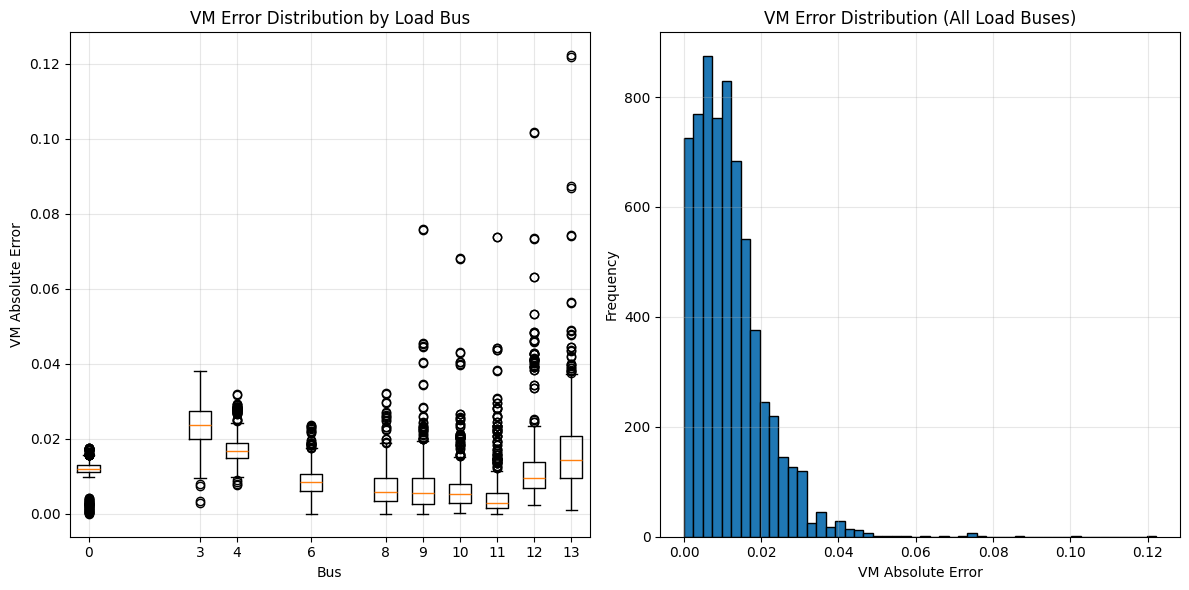

In [25]:
#PLOT THE ERRORS between actual and predicted values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pf_node = pd.read_csv(dir_path+"/pf_node.csv")
predictions = pd.read_csv(data_path+"/case14_ieee/predictions/predictions.csv")


gen_buses = [1, 2, 5, 7] #7 is Slack, so should I include or exclude ???
load_buses = [b for b in pf_node['bus'].unique() if b not in gen_buses]

print(f"Generator buses (excluded): {gen_buses}")
print(f"Load buses (compared): {load_buses}")

# Merge the dataframes
comparison = pf_node.merge(predictions, on=['scenario', 'bus'], how='inner')

comparison = comparison[comparison['bus'].isin(load_buses)]

comparison['VM_error'] = abs(comparison['Vm'] - comparison['VM_pred'])
comparison['VA_error'] = abs(comparison['Va'] - comparison['VA_pred'])
comparison['PD_error'] = abs(comparison['Pd'] - comparison['PD_pred'])
comparison['QD_error'] = abs(comparison['Qd'] - comparison['QD_pred'])

# Summary statistics
print("\n=== Error Summary (Load Buses Only) ===")
print(f"\nVM Error Statistics:")
print(comparison['VM_error'].describe())
print(f"\nVA Error Statistics:")
print(comparison['VA_error'].describe())

# Per-bus analysis
print("\n=== Per-Bus VM Error (Load Buses) ===")
bus_summary = comparison.groupby('bus').agg({
    'VM_error': ['mean', 'std', 'max'],
    'VA_error': ['mean', 'std', 'max'],
}).round(6)
print(bus_summary)

# Save comparison results
comparison_results = comparison[['scenario', 'bus', 'Vm', 'VM_pred', 'VM_error', 
                                  'Va', 'VA_pred', 'VA_error', 'Pd', 'PD_pred', 'PD_error',
                                  'Qd', 'QD_pred', 'QD_error']]
comparison_results.to_csv('vm_comparison_load_buses.csv', index=False)
print(f"\nSaved detailed comparison to vm_comparison_load_buses.csv")

# Optional: Plot VM errors
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for bus in load_buses:
    bus_data = comparison[comparison['bus'] == bus]['VM_error']
    plt.boxplot(bus_data, positions=[bus], widths=0.6)
plt.xlabel('Bus')
plt.ylabel('VM Absolute Error')
plt.title('VM Error Distribution by Load Bus')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(comparison['VM_error'], bins=50, edgecolor='black')
plt.xlabel('VM Absolute Error')
plt.ylabel('Frequency')
plt.title('VM Error Distribution (All Load Buses)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vm_error_analysis.png', dpi=150)
print("Saved error plots to vm_error_analysis.png")

Compare violations between predicted and actual values

In [26]:
import pandas as pd
import numpy as np

# Read data
# pf_edge = pd.read_csv(dir_path+"/pf_edge.csv")
pf_node = pd.read_csv(dir_path+"/pf_node.csv")
predictions = pd.read_csv(data_path+"/case14_ieee/predictions/predictions.csv")

# Parameters
vmax, vmin = 1.05, 0.95
line_loading_max = 1.0
gen_buses = [1, 2, 5, 7]  # Removed 0

print(f"Unique scenarios in predictions: {predictions['scenario'].nunique()}")

# Get scenarios that exist in BOTH files
common_scenarios = sorted(set(pf_node['scenario'].unique()) & set(predictions['scenario'].unique()))


# Analyze Pandapower results for COMMON scenarios only
pp_violations = []
for scenario in common_scenarios:
    scenario_buses = pf_node[pf_node['scenario'] == scenario]
    # scenario_lines = pf_edge[pf_edge['scenario'] == scenario]
    
    # Only check voltage on load buses
    load_buses = scenario_buses[~scenario_buses['bus'].isin(gen_buses)]
    vm = load_buses['Vm'].values
    
    # Count voltage violations
    lv_count = np.sum(vm < vmin)
    hv_count = np.sum(vm > vmax)
    
    # Count line overloading
    # in_service = scenario_lines['br_status'] == 1.0
    # active_lines = scenario_lines[in_service]
    
    pp_violations.append({
        'scenario': scenario,
        'pp_lv_count': lv_count,
        'pp_hv_count': hv_count
    })

pp_violations_df = pd.DataFrame(pp_violations)

# Analyze GridFM predictions for COMMON scenarios only
gf_violations = []
for scenario in common_scenarios:
    scenario_data = predictions[predictions['scenario'] == scenario]
    
    # Only check voltage on load buses
    load_data = scenario_data[~scenario_data['bus'].isin(gen_buses)]
    vm_pred = load_data['VM_pred'].values
    
    # Count voltage violations
    lv_count = np.sum(vm_pred < vmin)
    hv_count = np.sum(vm_pred > vmax)
    
    gf_violations.append({
        'scenario': scenario,
        'gf_lv_count': lv_count,
        'gf_hv_count': hv_count,
    })

gf_violations_df = pd.DataFrame(gf_violations)

# Merge and compare
comparison = pp_violations_df.merge(gf_violations_df, on='scenario', how='inner')
comparison['lv_mismatch'] = comparison['pp_lv_count'] != comparison['gf_lv_count']
comparison['hv_mismatch'] = comparison['pp_hv_count'] != comparison['gf_hv_count']

# Get scenarios with mismatches
mismatch_mask = comparison['lv_mismatch'] | comparison['hv_mismatch']
mismatched_scenarios = comparison[mismatch_mask]['scenario'].tolist()

# Print violation details for ALL mismatched scenarios
print("\n=== Investigating Violations in Mismatched Scenarios ===\n")

violation_details = []

for scenario in mismatched_scenarios:
    pp_data = pf_node[pf_node['scenario'] == scenario]
    gf_data = predictions[predictions['scenario'] == scenario]
    
    # Filter load buses only
    pp_load = pp_data[~pp_data['bus'].isin(gen_buses)]
    gf_load = gf_data[~gf_data['bus'].isin(gen_buses)]
    
    # Find low voltage buses in Pandapower
    pp_lv_mask = pp_load['Vm'] < vmin
    pp_hv_mask = pp_load['Vm'] > vmax
    
    # Check for violations
    if pp_lv_mask.any():
        print(f"--- Scenario {scenario}: LOW VOLTAGE violations ---")
        for _, row in pp_load[pp_lv_mask].iterrows():
            bus = row['bus']
            pp_vm = row['Vm']
            gf_row = gf_load[gf_load['bus'] == bus]
            if len(gf_row) > 0:
                gf_vm = gf_row.iloc[0]['VM_pred']
                error = pp_vm - gf_vm
                print(f"  Bus {bus}: PP_VM={pp_vm:.6f}, GF_VM={gf_vm:.6f}, Error={error:.6f}")
                violation_details.append({
                    'scenario': scenario,
                    'bus': bus,
                    'violation_type': 'LV',
                    'pp_value': pp_vm,
                    'gf_value': gf_vm,
                    'error': error
                })
    
    if pp_hv_mask.any():
        print(f"--- Scenario {scenario}: HIGH VOLTAGE violations ---")
        for _, row in pp_load[pp_hv_mask].iterrows():
            bus = row['bus']
            pp_vm = row['Vm']
            gf_row = gf_load[gf_load['bus'] == bus]
            if len(gf_row) > 0:
                gf_vm = gf_row.iloc[0]['VM_pred']
                error = pp_vm - gf_vm
                print(f"  Bus {bus}: PP_VM={pp_vm:.6f}, GF_VM={gf_vm:.6f}, Error={error:.6f}")
                violation_details.append({
                    'scenario': scenario,
                    'bus': bus,
                    'violation_type': 'HV',
                    'pp_value': pp_vm,
                    'gf_value': gf_vm,
                    'error': error
                })

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Scenarios with perfect agreement: {np.sum(~mismatch_mask)}")
print(f"Scenarios with LV count mismatches: {comparison['lv_mismatch'].sum()}")
print(f"Scenarios with HV count mismatches: {comparison['hv_mismatch'].sum()}")
print(f"Percentage agreement (LV): {100*np.mean(~comparison['lv_mismatch']):.2f}%")
print(f"Percentage agreement (HV): {100*np.mean(~comparison['hv_mismatch']):.2f}%")

if violation_details:
    violation_df = pd.DataFrame(violation_details)
    print(f"\nMean error: {violation_df['error'].mean():.6f}")
    print(f"Max error: {violation_df['error'].max():.6f}")
    print(f"Min error: {violation_df['error'].min():.6f}")

Unique scenarios in predictions: 1318

=== Investigating Violations in Mismatched Scenarios ===

--- Scenario 9: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.946536, GF_VM=0.987400, Error=-0.040864
--- Scenario 39: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.946527, GF_VM=0.987409, Error=-0.040882
--- Scenario 69: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.946179, GF_VM=0.987175, Error=-0.040995
--- Scenario 84: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.948283, GF_VM=0.986516, Error=-0.038234
--- Scenario 99: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.946392, GF_VM=0.987531, Error=-0.041139
--- Scenario 114: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.949334, GF_VM=0.989459, Error=-0.040125
--- Scenario 129: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.947223, GF_VM=0.986724, Error=-0.039501
--- Scenario 159: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.944385, GF_VM=0.987097, Error=-0.042712
--- Scenario 174: LOW VOLTAGE violations ---
  Bus 12.0: PP_VM=0.9392

BELOW CODE NOT USED, JUST PUT FOR REFERENCE

In [ ]:
import torch
from torch_geometric.data import Data
from gridfm_graphkit.models.gps_transformer import GPSTransformer
import yaml

config_path = "case14_finetune.yaml"
model_path = "../../gridfm-graphkit/examples/models/GridFM_v0_2.pth"

with open(config_path, "r") as f:
    config_dict = yaml.safe_load(f)
config_args = NestedNamespace(**config_dict)

class SimpleModel(torch.nn.Module):
    def __init__(self, config_args):
        super().__init__()
        self.model = GPSTransformer(config_args)
        self.config = config_args
        
    def forward(self, x, pe, edge_index, edge_attr, batch):
        return self.model(x, pe, edge_index, edge_attr, batch)

model = SimpleModel(config_args)
state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(state_dict, strict=False)  # Use strict=False to ignore extra keys
model.eval()

# You'll also need normalizers - you'll need to load these from your data
def denormalize_features(normalized_features, baseMVA=100):
    """Simple denormalization assuming baseMVA normalization"""
    denormed = normalized_features.copy()
    # Power features are normalized by baseMVA
    denormed[:, 0:4] *= baseMVA  # PD, QD, PG, QG
    return denormed



def run_gridfm_inference(pf_data, baseMVA=100):
    """
    Run GridFM inference on a single power flow case.
    Reference Code: gridfm-graphkit/gridfm_graphkit/datasets/powergrid_dataset.py (line 140 - 174)
    
    Args:
        pf_data: Dictionary with keys 'bus', 'gen', 'branch', 'Y_bus'
        baseMVA: Base MVA for denormalization
    
    Returns:
        Dictionary with predicted values
    """
    # Extract node features from bus data
    # BUS_COLUMNS: bus, Pd, Qd, Pg, Qg, Vm, Va, PQ, PV, REF, vn_kv, min_vm_pu, max_vm_pu, GS, BS
    bus_data = pf_data['bus']
    
    # Node features: [Pd, Qd, Pg, Qg, Vm, Va, PQ, PV, REF] normalized
    node_features = np.column_stack([
        bus_data[:, 1] / baseMVA,  # Pd normalized
        bus_data[:, 2] / baseMVA,  # Qd normalized
        bus_data[:, 3] / baseMVA,  # Pg normalized
        bus_data[:, 4] / baseMVA,  # Qg normalized
        bus_data[:, 5],  # Vm (already in p.u.)
        bus_data[:, 6] / 100,  # Va normalized (assume max 100 degrees)
        bus_data[:, 7],  # PQ
        bus_data[:, 8],  # PV
        bus_data[:, 9],  # REF
    ])
    

    y_bus = pf_data['Y_bus']
    edge_index = y_bus[:, 0:2].T.astype(int)  # [2, num_edges]
    edge_attr = y_bus[:, 2:4] / baseMVA  # G, B normalized
    

    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
    edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float32)
    
    # PE
    from gridfm_graphkit.datasets.transforms import AddNormalizedRandomWalkPE, AddEdgeWeights
    from torch_geometric.data import Data

    temp_data = Data(
        edge_index=edge_index_tensor,
        edge_attr=edge_attr_tensor,
        num_nodes=len(bus_data)
    )
    
    pe_pre_transform = AddEdgeWeights() #PE?
    temp_data = pe_pre_transform(temp_data) #PE?
    pe_transform = AddNormalizedRandomWalkPE(walk_length=20, attr_name="pe") #PE?
    temp_data = pe_transform(temp_data) #PE?
    pe_tensor = temp_data.pe
    

    x = torch.tensor(node_features, dtype=torch.float32)
    batch = torch.zeros(len(bus_data), dtype=torch.long)
    
    #inference
    with torch.no_grad():
        output = model(x, pe_tensor, edge_index_tensor, edge_attr_tensor, batch)
        output_np = output.numpy()
    
    # Denormalize
    output_denorm = denormalize_features(output_np, baseMVA)
    
    return {
        'PD_pred': output_denorm[:, 0],
        'QD_pred': output_denorm[:, 1],
        'PG_pred': output_denorm[:, 2],
        'QG_pred': output_denorm[:, 3],
        'VM_pred': output_denorm[:, 4],
        'VA_pred': output_denorm[:, 5] * 100,  # Convert back to degrees
    }




In [ ]:
print("net.res_bus\n",net.res_bus)
print("net.res_line\n",net.res_line)
print("net.res_trafo\n",net.res_trafo)
print("net.res_load\n",net.res_load)
print("net.res_gen\n",net.res_gen)
print("net.res_ext_grid\n",net.res_ext_grid)